In [2]:
%load_ext autoreload

%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import glob
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns

from pprint import pprint

import re
from scipy.signal import correlate2d

import scipy

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import SNOM_Import
import hdf5storage

import scipy.io as sio


In [4]:
sys.path.append('/mnt/c/Users/conor/Git_Projects/PHD')

In [5]:
files = dict()

for i, file_path in tqdm(enumerate(glob.glob("/mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant/*HEADR*")[:])):

    file_name = file_path.split('/')[-1].split('HEADR')[0]
    files[file_name] = SNOM_Import.SNOM_File(file_path[:-14])

snom_files = pd.DataFrame({name: vars(file) for name, file in files.items()}).T


In [6]:
metadata = pd.read_excel('Insulin_Data_Summary_3.xlsx')
#metadata = metadata.drop_duplicates(subset='Scan Number')
#metadata.to_excel('metadata_nd.xlsx')

In [ ]:
snom_files.index = [int(i[:4]) for i in snom_files.index]

In [7]:
df = snom_files.loc[:,['FSNOM','BSNOM']].reset_index().merge(metadata.reset_index(), left_on='index', right_on='index')

NameError: name 'metadata' is not defined

In [9]:
df.query("index in [2657,2658,2659]").apply(lambda row: row.FSNOM.shape,axis=1)

76    (100, 100)
77    (100, 100)
78    (100, 100)
dtype: object

In [10]:
a = [2657,2658,2659]
b = [2275,2276,2277]

df.FSNOM = df.apply(lambda row: row.FSNOM[:,:50] if (row['index'] in a) else (row.FSNOM[100:,:] if row['index'] in b else row.FSNOM[:,:]), axis=1)
# elif row.index in b row.FSNOM[:] else row.FSNOM)

In [12]:
df.FSNOM.apply(lambda row: row.shape).tolist()

df.to_excel('Full_set.xlsx')

In [13]:
for batch_n, df_ in df.groupby('Batch'):

    fig, axes = plt.subplots(ncols=2, nrows=2)
    [ax.axis('off') for ax in axes.flatten()]

    for (index, row), ax in zip(df_.T.iteritems(), axes.flatten()):

        sensitivity = int(row.sensitivity.replace(' ','')[0])

        try:
            #bkg = bkgs[row.background_scan][row.wavenumber]
            ims=ax.imshow(row.FSNOM*sensitivity)
            ax.set_title(f'{index}\n'+ '\n'.join(row[['wavenumber','scan_size']]))
            fig.colorbar(ims, ax=ax)

        except:
            pass

    fig.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/Work_For_Caroline/Plots_15_10_2020/{batch_n}.png', bbox_inches='tight')
        



In [67]:
for i, row in df.query("background_scan=='none' & Accept in ['y','Y']").iterrows():

    if row.FSNOM.min() < 0:
        plt.title(row.index)
        plt.imshow(row.FSNOM)

C6 on Au with HI pH 2     31
C6/Au                     30
C18 on Au with HI pH 2    27
C18 on Au with HI pH 7    21
C6 on Au with HI pH 7     18
Au                        15
C18/Au                     9
Name: sample, dtype: int64

1626 Au
1651 Au
1689 Au
1626 C18/Au
1651 C18/Au
1689 C18/Au
1626 C6/Au
1651 C6/Au
1689 C6/Au


Text(0.5, 0, 'Pixel Intensity')

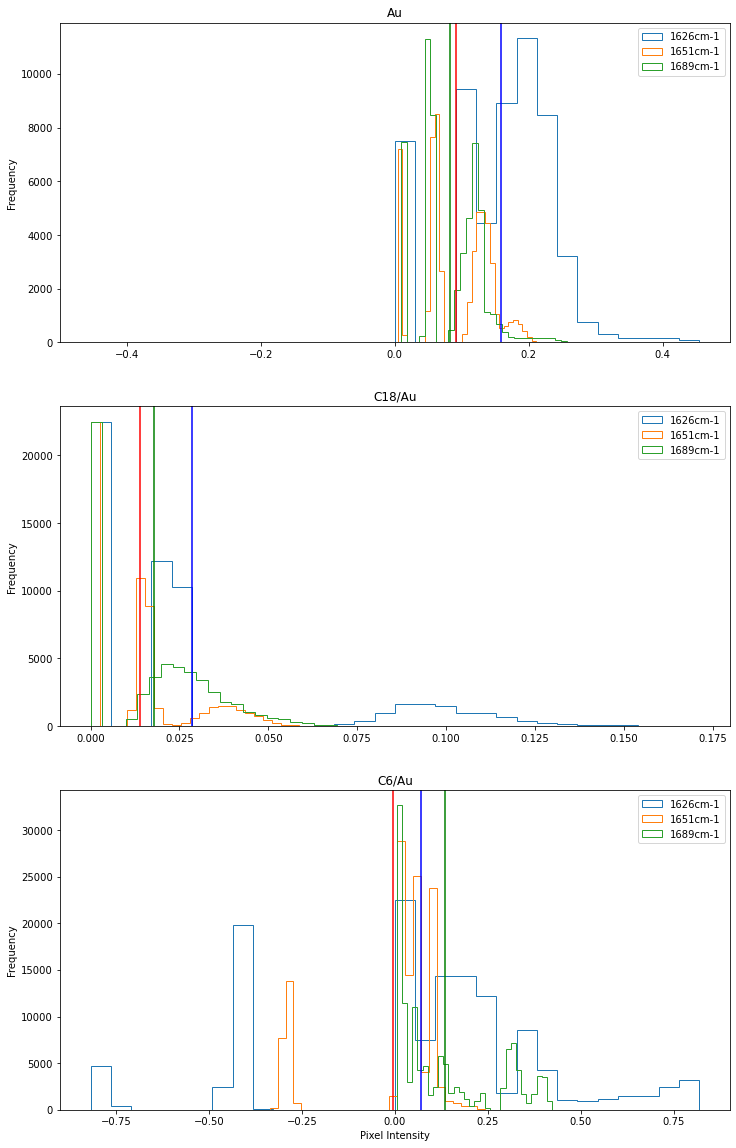

In [15]:
df.loc[:,['index','Batch','Accept','sample']]['sample'].value_counts().index#.query("sample=='C6 on A with HI ph 2'")

fig, axes = plt.subplots(nrows=3, figsize=(12,20), sharex=False)

# Dictionary containing the expectation value for each 
# total background and each wavelength
bkgs={}

df['wavenumber']=df.apply(lambda row: row['wavenumber'].replace(' ',''), axis=1)
dataset=df.query("background_scan=='none'")

for ax, (name, df_) in zip(axes.flatten(), dataset.groupby('sample')):

    wns={}
    for c, (wn, df_wn) in zip(['b','r','g'], df_.groupby('wavenumber')):
        
        wn=wn[:4]
        print(wn.replace(' ',''), name)

        # Extract the sensitivity of the lock in for each image.
        sens = [int(re.search("(-?[0-9]+)", col).groups()[0]) for col in df_wn.sensitivity]
        pulse_rate = [int(re.search("(-?[0-9]+)", col).groups()[0]) for col in df_wn.pulse_rate]
        pulse_width = [int(re.search("(-?[0-9]+)", col).groups()[0]) for col in df_wn.pulse_width]

        ims = np.concatenate([im.flatten()*sen/(pr*pw) for im, sen, pr, pw in zip(df_wn.FSNOM, sens, pulse_rate, pulse_width)])


        hist, bins = np.histogram(ims, bins=30)

        #print(hist.min(), bins.min())

        width = 0.7 * (bins[1] - bins[0])
        center = (bins[:-1] + bins[1:]) / 2

        # Calculate expectation value of distribution
        exp = np.sum(center*(hist/hist.sum()))
        
        # Plot histograms and expectation value
        ax.axvline(exp, c=c)
        ax.hist(ims, bins=30, label=f'{wn.replace(" ","")}cm-1', histtype='step')

        wns[wn.replace(" ","")] = exp

    bkgs[name]=wns

    ax.set_title(f'{name}')
    ax.set_ylabel('Frequency')
    ax.legend()

ax.set_xlabel('Pixel Intensity')

In [16]:
Generate Image files for Caroline

test_images={}

for file_ in tqdm(glob.glob('/mnt/c/Users/conor/Google Drive/PhD/SNOM_Creep_Corrected/*.mat')):

    file_dict = hdf5storage.loadmat(file_)

    for file_name, _file in file_dict.items():

        #try:
        snom_file=files[file_name[4:]+'-0-']
        
        sens = int(re.search("([0-9]+)", snom_file.sensitivity).groups()[0])

        try:
            bkg_scan=bkgs[df.loc[snom_file.name+'-','background_scan']][snom_file.wavenumber.replace(' ','')]
        except:
            continue

        FSNOM = (_file[0][0][0][0]*sens)#/bkg_scan
        BSNOM = (_file[0][0][0][1]*sens)#/bkg_scan
        FZERO = _file[0][0][0][2]
        BZERO = _file[0][0][0][3]
        FTOPO = _file[0][0][0][4]
        BTOPO = _file[0][0][0][5]

        FSNOM_Tilt_Corrected = SNOM_Import.plane_correct(_file[0][0][0][0])
        BSNOM_Tilt_Corrected = SNOM_Import.plane_correct(_file[0][0][0][1])
        FTOPO_Tilt_Corrected = SNOM_Import.plane_correct(_file[0][0][0][4])
        BTOPO_Tilt_Corrected = SNOM_Import.plane_correct(_file[0][0][0][5])

        data_files={
            'Name': file_name[4:]+'-0-',
            'FSNOM': FSNOM,
            'BSNOM': BSNOM,
            'FZERO': FZERO,
            'BZERO': BZERO,
            'FTOPO': FTOPO,
            'BTOPO': BTOPO,
            'FSNOM_Tilt_Corrected': FSNOM_Tilt_Corrected,
            'BSNOM_Tilt_Corrected': BSNOM_Tilt_Corrected,
            'FTOPO_Tilt_Corrected': FTOPO_Tilt_Corrected,
            'BTOPO_Tilt_Corrected': BTOPO_Tilt_Corrected,
        }

        test_images[file_name[4:]+'-0-'] = data_files

        file_path = os.path.join(os.getcwd(), 'tilt_corrected_files', 'CS')
        file_name = snom_file.name+'.mat'
        
        try: os.mkdir(file_path)
        except: pass

        sio.savemat(os.path.join(file_path, file_name), mdict=data_files)


for n, row in df.loc[['2750-0-','2751-0-','2752-0-'], ['wavenumber', 'FSNOM', 'BSNOM', 'FTOPO']].iterrows():
    
    fig, (ax1, ax2) = plt.subplots(ncols=2)

    im = row.FSNOM

    fig.suptitle(n)
    ax1.imshow(im)
    ax2.imshow(SNOM_Import.plane_correct(im))

Text(0.5, 0, 'Pixel Intensity')

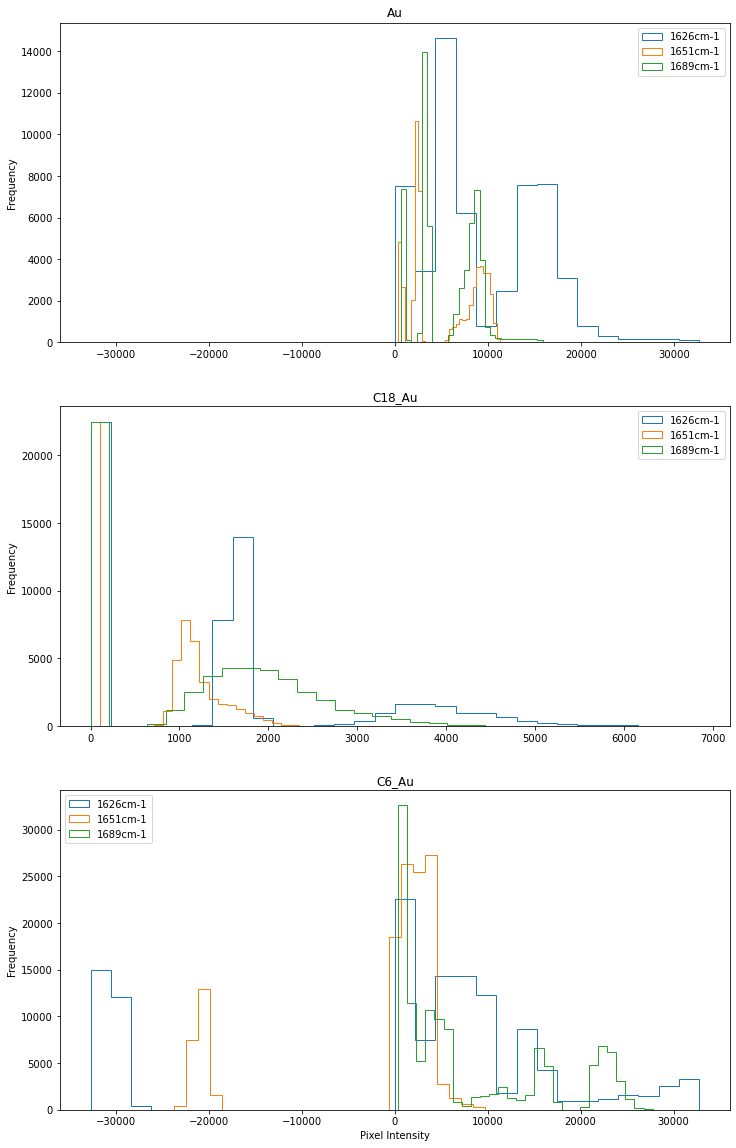

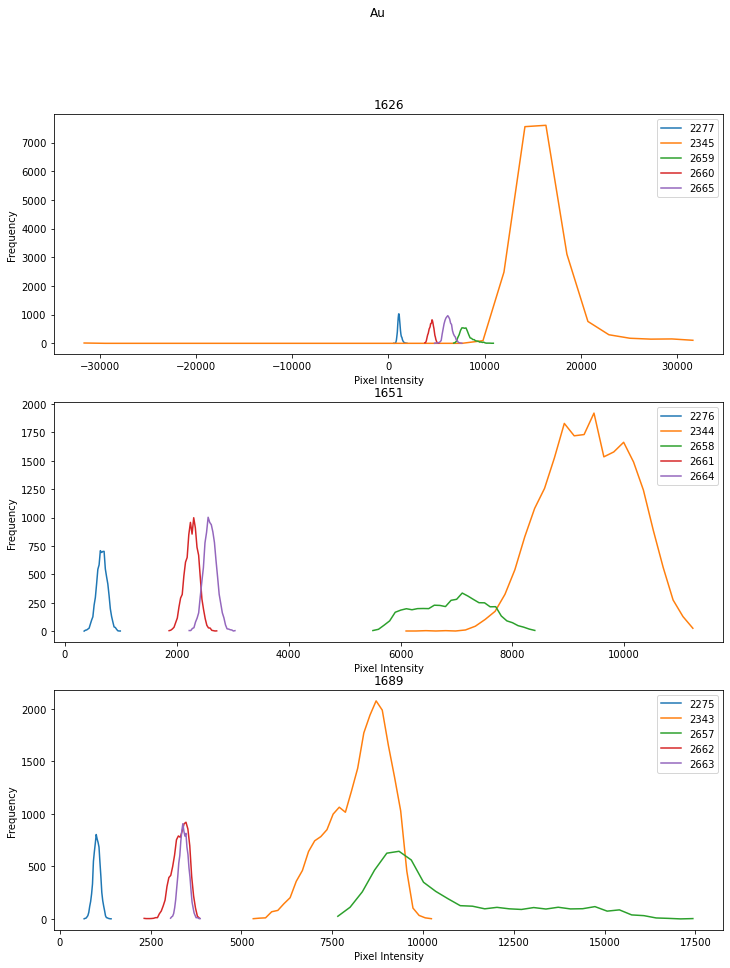

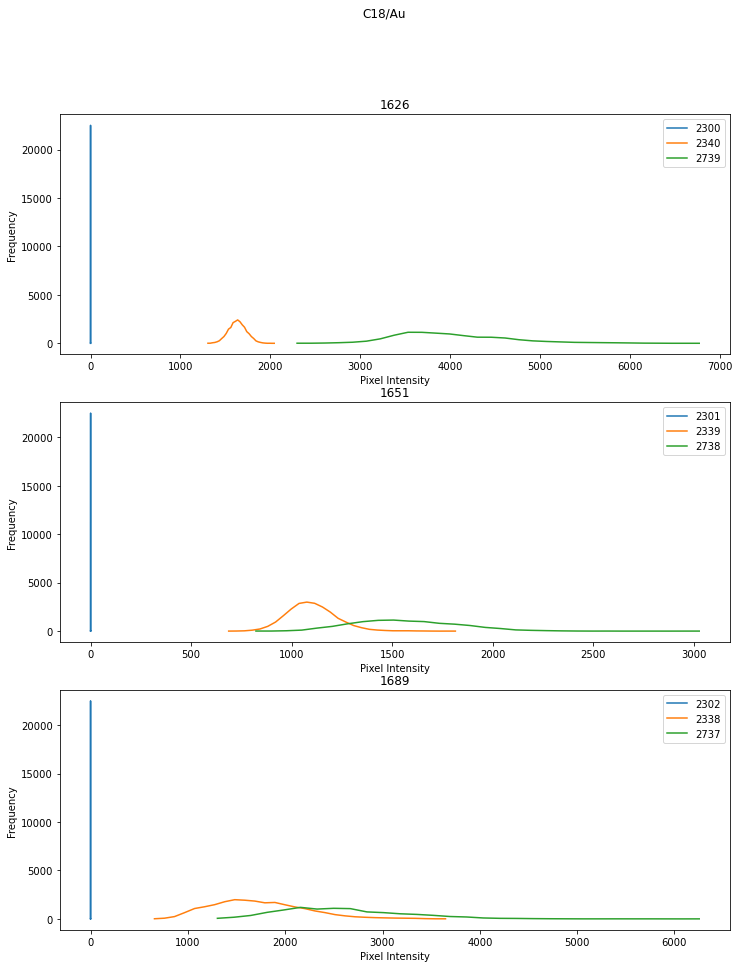

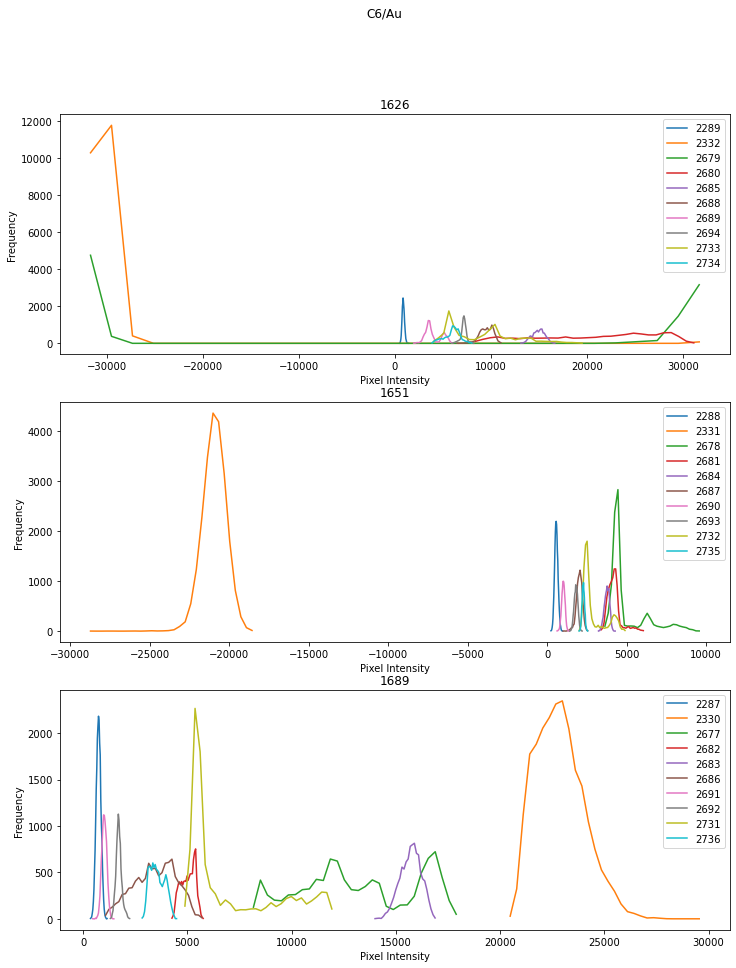

In [32]:
fig, ax = plt.subplots()

for n, row in df.loc[['2714-0-','2715-0-','2716-0-'], ['wavenumber', 'FSNOM']].iterrows():

    ax.hist(row.FSNOM.flatten(), label=f'{n} - {row.wavenumber}', histtype='step', bins=30)

plt.legend()

Text(0.5, 0, 'Pixel Intensity')

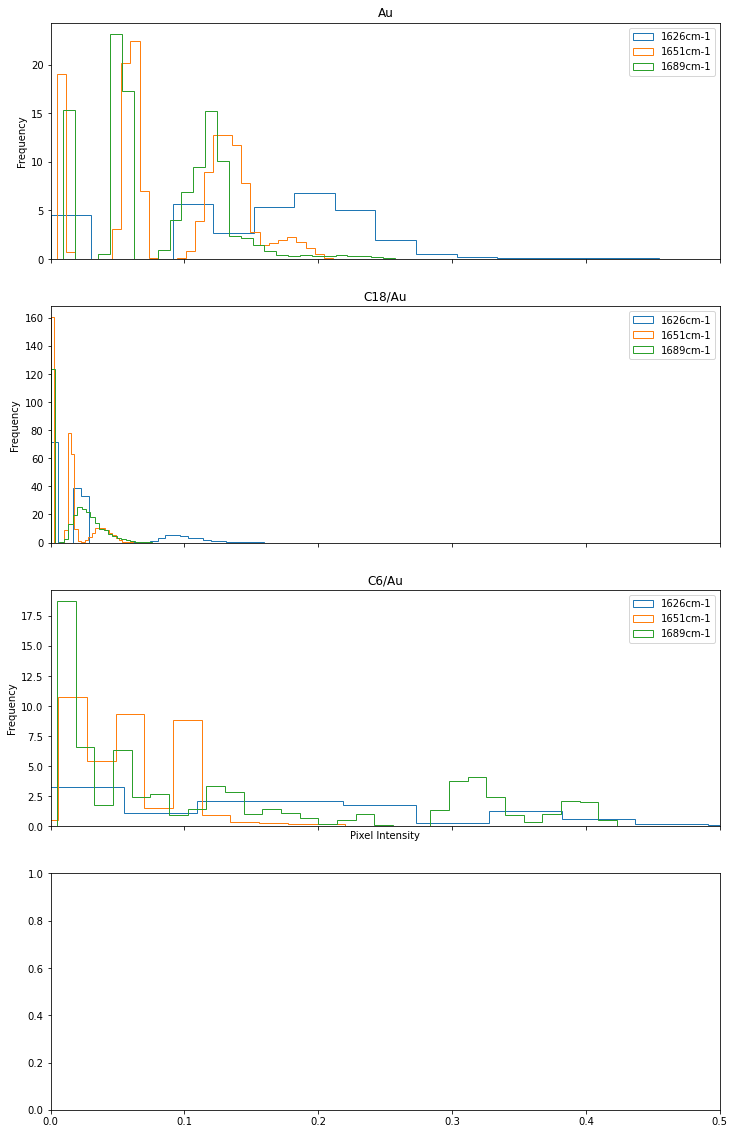

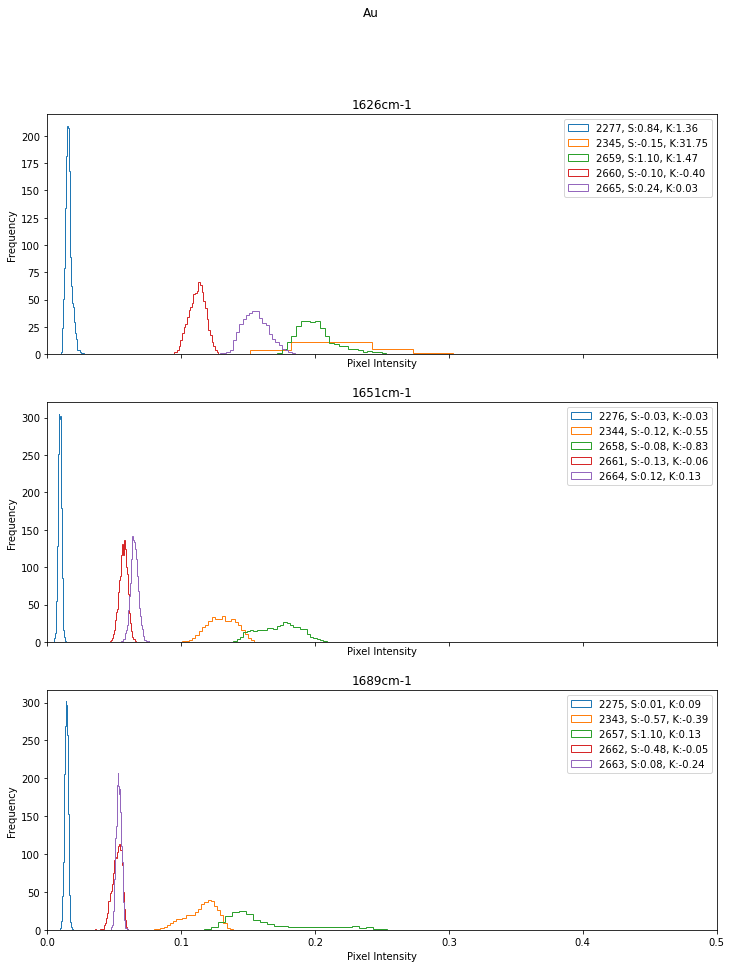

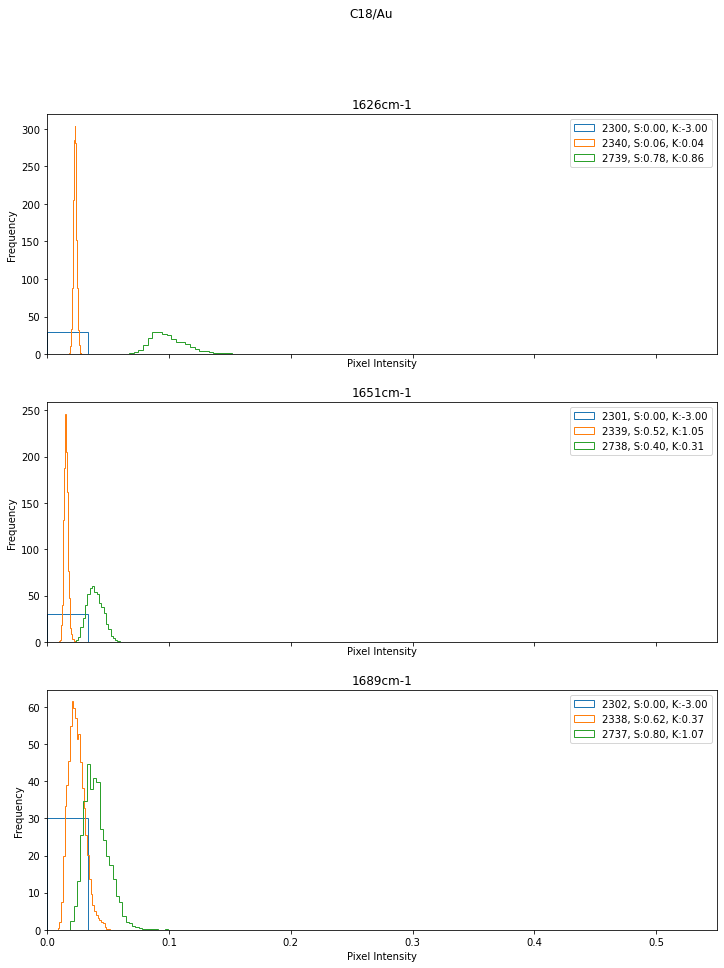

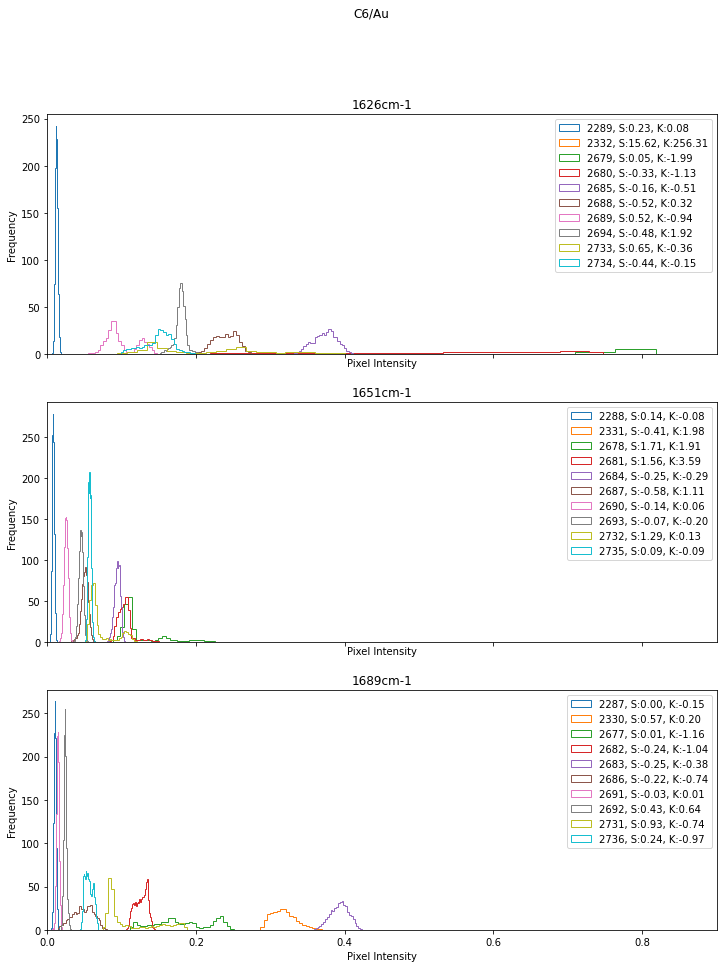

In [34]:
fig, axes = plt.subplots(nrows=8, figsize=(12,20), sharex=False)

dataset = df.query("background_scan=='none' & Accept in ['y','Y']")
dataset = df
dataset['wavenumber']=dataset.apply(lambda row: row['wavenumber'].replace(' ',''), axis=1)

for ax, (name, df_) in zip(axes.flatten(), dataset.groupby('sample')):

    wns={}

    fig2, axes2 = plt.subplots(nrows=3, figsize=(12,15), sharex=False)
    fig2.suptitle(f'{name}')


    for c, ax2, (wn, df_wn) in zip(['blue','orange','green','r'], axes2.flatten(), df_.groupby('wavenumber')):

        wn=wn[:4]

        # Extract the sensitivity of the lock in for each image.
        sens = [int(re.search("([0-9]+)", col).groups()[0]) for col in df_wn.sensitivity]

        total=[]

        #bkg = bkgs[df_wn.background_scan.tolist()[0]][wn]
        
        # For each image make the histogram
        for i, (idx, row) in enumerate(df_wn.iterrows()):
            
            fbsnom = []
            fbsnom.append(np.concatenate(row.FSNOM))
            
            sensitivity = int(re.search("([0-9]+)", row.sensitivity).groups()[0])

            fbsnom = np.concatenate(fbsnom)

            text_x = (fbsnom.mean()*sensitivity)#/bkg
            #ax.text(text_x-(0.05*text_x), i*20, f"{row['Scan Number']}")

            hist, bins = np.histogram((fbsnom.flatten()*sensitivity), bins=30)

            width = 0.7* (bins[1] - bins[0])
            center = (bins[:-1] + bins[1:]) / 2 

            #ax.plot(center,hist,color=c,label=f"{row['Scan Number']}",ls=ls)
            ax2.plot(center,hist, label=f"{row['Scan Number']}")

            total.append((fbsnom.flatten()*sensitivity))#/bkg)

        total = np.concatenate(total)

        ax2.set_title(wn)

        ax2.set_ylabel('Frequency')
        ax2.set_xlabel('Pixel Intensity')
        ax2.legend()

        name=name.replace('/','_')

        fig2.savefig(f'./Work_For_Caroline/20_11/{name}.pdf', bbox_inches='tight')
        ax.hist(total.flatten(), bins=len(hist), label=f'{wn}cm-1', histtype='step')

    ax.set_title(f'{name}')
    ax.set_ylabel('Frequency')
    ax.legend()

ax.set_xlabel('Pixel Intensity')
#fig.savefig('/mnt/c/Users/conor/Git_Projects/PHD/Work_For_Caroline/20_11/Total.pdf', bbox_inches='tight')

In [35]:
fig, axes = plt.subplots(nrows=4, figsize=(12,20), sharex=True)

dataset = df.query("background_scan=='none' & Accept in ['y','Y']")
dataset = df.query("background_scan=='none'")
dataset['wavenumber']=dataset.apply(lambda row: row['wavenumber'].replace(' ',''), axis=1)

for ax, (name, df_) in zip(axes.flatten(), dataset.groupby('sample')):

    wns={}

    fig2, axes2 = plt.subplots(nrows=3, figsize=(12,15), sharex=True)
    fig2.suptitle(f'{name}')

    for c, ax2, (wn, df_wn) in zip(['blue','orange','green','r'], axes2.flatten(), df_.groupby('wavenumber')):

        wn=wn[:4]

        # Extract the sensitivity of the lock in for each image.
        #sens = [int(re.search("([0-9]+)", col).groups()[0]) for col in df_wn.sensitivity]
        #pw = [int(re.search("([0-9]+)", col).groups()[0]) for col in df_wn.pulse_width]

        total=[]

        #bkg = bkgs[df_wn.background_scan.tolist()[0]][wn]
        
        # For each image make the histogram
        for i, (idx, row) in enumerate(df_wn.iterrows()):
            
            fbsnom = []

            for im in [row.FSNOM]:
                try:
                    fbsnom.append(np.concatenate(im))
                except:
                    pass
            
            sensitivity = int(re.search("([0-9]+)", row.sensitivity).groups()[0])
            pulse_width = int(re.search("([0-9]+)", row.pulse_width).groups()[0])
            pulse_rate = int(re.search("([0-9]+)", row.pulse_rate).groups()[0])

            fbsnom = np.concatenate(fbsnom)

            sk = scipy.stats.skew((fbsnom.flatten()*sensitivity)/(pulse_width*pulse_rate))
            ku = scipy.stats.kurtosis((fbsnom.flatten()*sensitivity)/(pulse_width*pulse_rate))


            ax2.hist((fbsnom.flatten()*sensitivity)/(pulse_width*pulse_rate)
            , histtype='step'
            , label=f"{row['Scan Number']}, S:{sk:.2f}, K:{ku:.2f}"
            , bins=30
            , density=True)

            hist, bins = np.histogram((fbsnom.flatten()*sensitivity)/(pulse_width*pulse_rate), bins=30)

            width = 0.7* (bins[1] - bins[0])
            center = (bins[:-1] + bins[1:]) / 2 

            #ax.plot(center,hist,color=c,label=f"{row['Scan Number']}",ls=ls)
            #ax2.plot(center,hist, label=f"{row['Scan Number']}")

            total.append((fbsnom.flatten()*sensitivity)/(pulse_width*pulse_rate))

        total = np.concatenate(total)

        ax2.set_title(f'{wn}cm-1')

        ax2.set_ylabel('Frequency')
        ax2.set_xlabel('Pixel Intensity')
        ax2.legend()
        ax2.set_xlim(left=0)

        #fig2.savefig(f'./Work_For_Caroline/20_11/{name}.pdf', bbox_inches='tight')
        ax.hist(total.flatten()
        , bins=30
        , label=f'{wn}cm-1'
        , histtype='step'
        , density=True)

    ax.set_title(f'{name}')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.set_xlim(left=0)

ax.set_xlabel('Pixel Intensity')
#fig.savefig('/mnt/c/Users/conor/Git_Projects/PHD/Work_For_Caroline/20_11/Total.pdf', bbox_inches='tight')

{'Au': {'1626': 0.15901594801346805,
  '1651': 0.09213196767676766,
  '1689': 0.08269793055555556},
 'C18/Au': {'1626': 0.02861748072727273,
  '1651': 0.013894822181818178,
  '1689': 0.01787423712121212},
 'C6/Au': {'1626': 0.07132868219999998,
  '1651': -0.004427941600000007,
  '1689': 0.13549942953333333}}

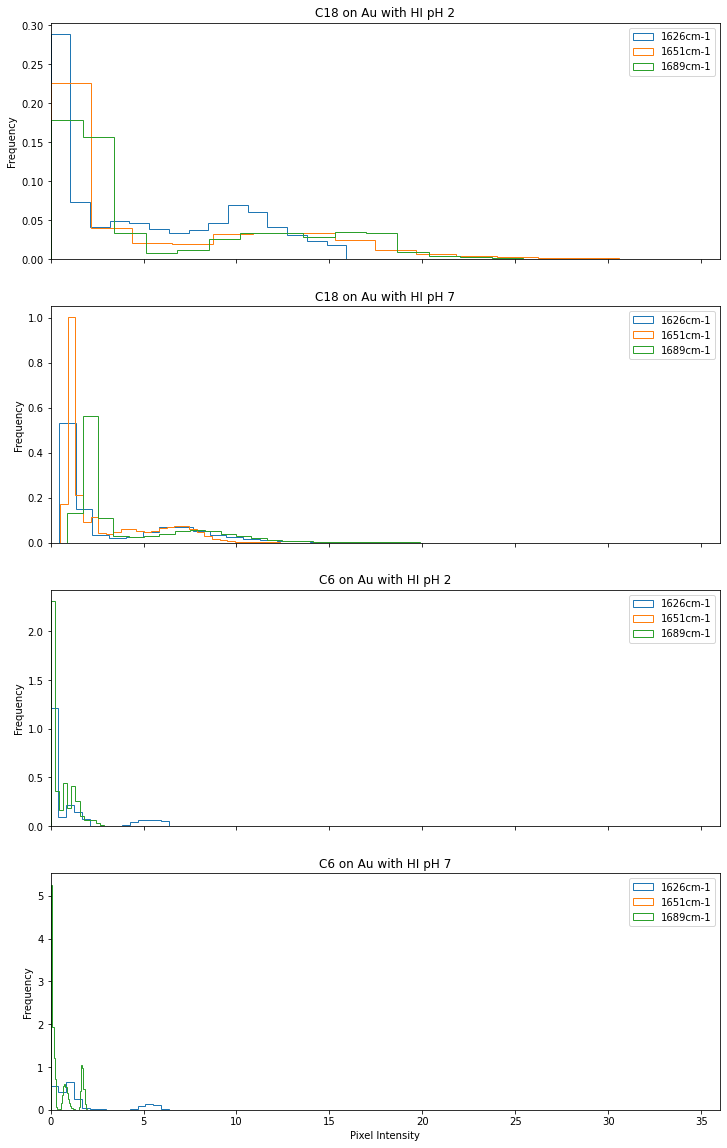

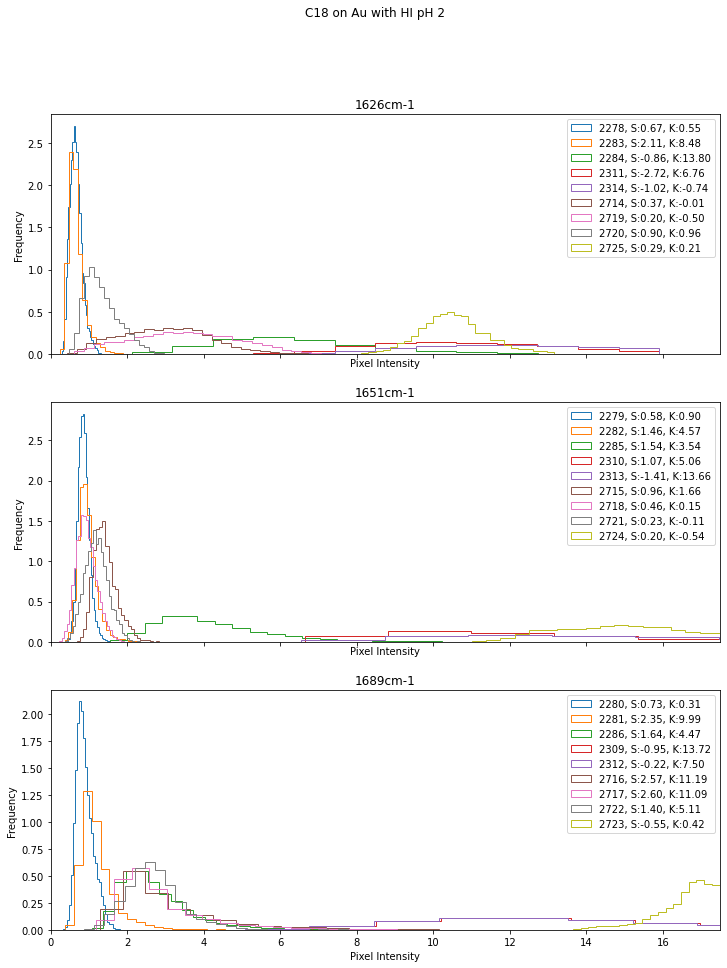

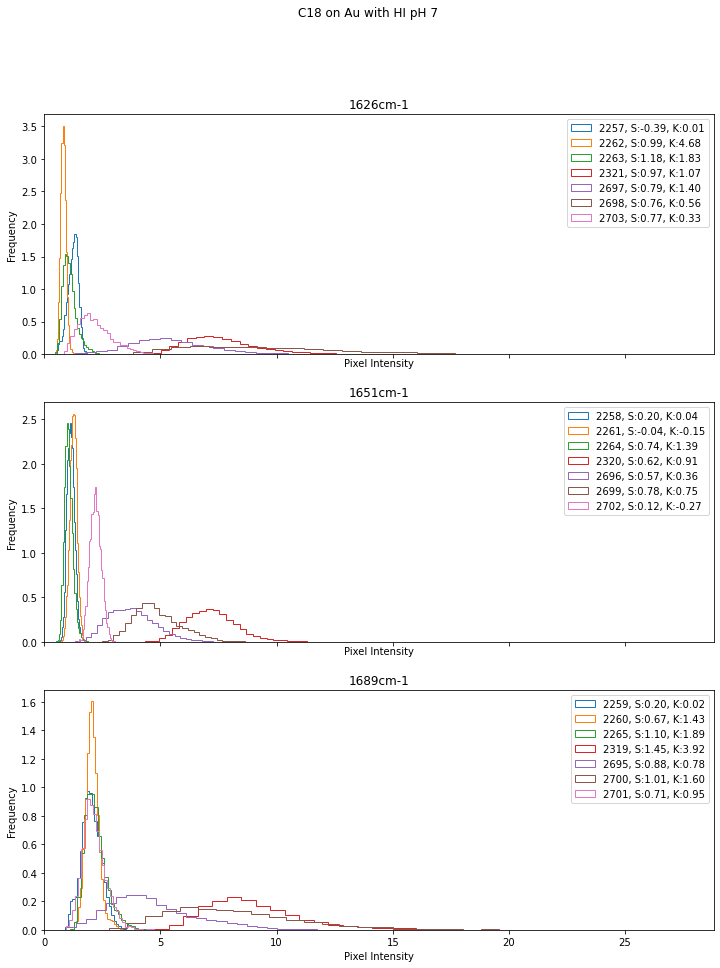

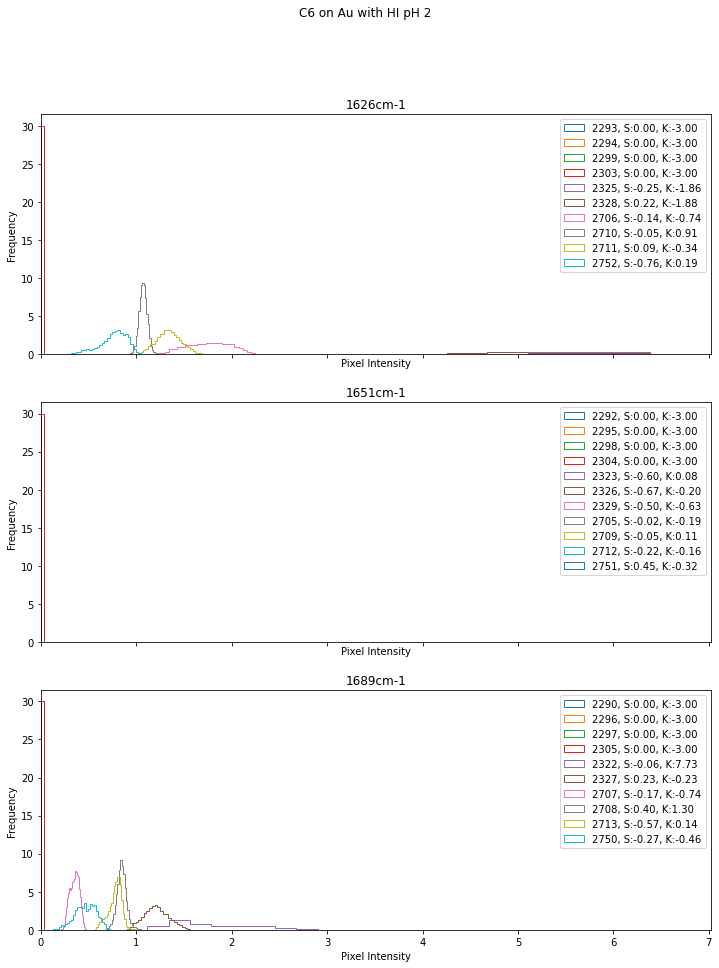

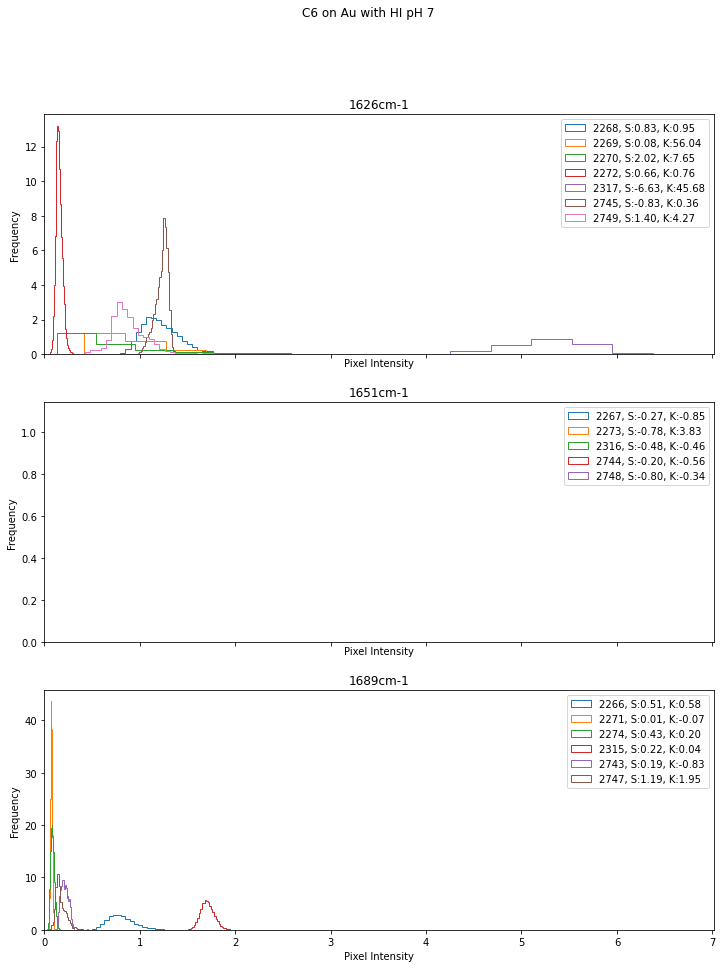

In [36]:
bkgs

In [54]:
fig, axes = plt.subplots(nrows=4, figsize=(12,20), sharex=True)

dataset = df.query("background_scan!='none' & Accept in ['y','Y']")
dataset = df.query("background_scan!='none'")
dataset['wavenumber']=dataset.apply(lambda row: row['wavenumber'].replace(' ',''), axis=1)

for ax, (name, df_) in zip(axes.flatten(), dataset.groupby('sample')):

    wns={}

    fig2, axes2 = plt.subplots(nrows=3, figsize=(12,15), sharex=True)
    fig2.suptitle(f'{name}')

    for c, ax2, (wn, df_wn) in zip(['blue','orange','green','r'], axes2.flatten(), df_.groupby('wavenumber')):

        wn=wn[:4]

        # Extract the sensitivity of the lock in for each image.
        #sens = [int(re.search("([0-9]+)", col).groups()[0]) for col in df_wn.sensitivity]
        #pw = [int(re.search("([0-9]+)", col).groups()[0]) for col in df_wn.pulse_width]

        total=[]

        bkg = bkgs[df_wn.background_scan.tolist()[0]][wn]
        
        # For each image make the histogram
        for i, (idx, row) in enumerate(df_wn.iterrows()):
            
            fbsnom = []

            for im in [row.FSNOM]:
                try:
                    fbsnom.append(np.concatenate(im))
                except:
                    pass
            
            sensitivity = int(re.search("([0-9]+)", row.sensitivity).groups()[0])
            pulse_width = int(re.search("([0-9]+)", row.pulse_width).groups()[0])
            pulse_rate = int(re.search("([0-9]+)", row.pulse_rate).groups()[0])

            fbsnom = np.concatenate(fbsnom)

            sk = scipy.stats.skew((fbsnom.flatten()*sensitivity)/(bkg*pulse_width*pulse_rate))
            ku = scipy.stats.kurtosis((fbsnom.flatten()*sensitivity)/(bkg*pulse_width*pulse_rate))
            


            ax2.hist((fbsnom.flatten()*sensitivity)/(bkg*pulse_width*pulse_rate)
            , histtype='step'
            , label=f"{row['Scan Number']}, S:{sk:.2f}, K:{ku:.2f}"
            , bins=30
            , density=True)

            hist, bins = np.histogram((fbsnom.flatten()*sensitivity)/(bkg*pulse_width*pulse_rate), bins=30)

            width = 0.7* (bins[1] - bins[0])
            center = (bins[:-1] + bins[1:]) / 2 

            #ax.plot(center,hist,color=c,label=f"{row['Scan Number']}",ls=ls)
            #ax2.plot(center,hist, label=f"{row['Scan Number']}")

            total.append((fbsnom.flatten()*sensitivity)/(bkg*pulse_width*pulse_rate))

        total = np.concatenate(total)

        ax2.set_title(f'{wn}cm-1')

        ax2.set_ylabel('Frequency')
        ax2.set_xlabel('Pixel Intensity')
        ax2.legend()
        ax2.set_xlim(left=0)

        fig2.savefig(f'./Work_For_Caroline/20_11/{name}.pdf', bbox_inches='tight')
        ax.hist(total.flatten()
        , bins=30
        , label=f'{wn}cm-1'
        , histtype='step'
        , density=True)

    ax.set_title(f'{name}')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.set_xlim(left=0)

ax.set_xlabel('Pixel Intensity')
fig.savefig('/mnt/c/Users/conor/Git_Projects/PHD/Work_For_Caroline/20_11/Total.pdf', bbox_inches='tight')

C6 on Au with HI pH 2     31
C6/Au                     30
C18 on Au with HI pH 2    27
C18 on Au with HI pH 7    21
C6 on Au with HI pH 7     18
Au                        15
C18/Au                     9
Name: sample, dtype: int64

In [9]:
# Batched plots

NameError: name 'df' is not defined

In [8]:
sensitivity = int(re.search("([0-9]+)", row.sensitivity).groups()[0])
pulse_width = int(re.search("([0-9]+)", row.pulse_width).groups()[0])
pulse_rate = int(re.search("([0-9]+)", row.pulse_rate).groups()[0])

NameError: name 'd' is not defined

In [94]:
dataset = df.query("background_scan!='none' & Accept in ['y','Y']")

dataset['Wavenumber']=dataset.apply(lambda row: row['wavenumber'].replace(' ','')[:4], axis=1)

dataset['sensitivity'] = dataset.apply(lambda row: int(re.search("([0-9]+)", row.sensitivity).groups()[0]), axis=1)
dataset['pulse_width'] = dataset.apply(lambda row: int(re.search("([0-9]+)", row.pulse_width).groups()[0]), axis=1)
dataset['pulse_rate']  = dataset.apply(lambda row: int(re.search("([0-9]+)", row.pulse_rate).groups()[0]) , axis=1)
dataset['Background'] =  dataset.apply(lambda row: bkgs[row['background_scan']][row['Wavenumber']], axis=1)

dataset['Transmittance']=dataset.apply(lambda row: ((row['FSNOM'].flatten()*row.sensitivity)/(row.Background*row.pulse_rate*row.pulse_width)), axis=1)

index                                              FSNOM  \
42   2300  [[940, 973, 978, 893, 811, 850, 870, 878, 831,...   
43   2301  [[491, 620, 772, 942, 975, 891, 734, 734, 794,...   
44   2302  [[489, 481, 526, 569, 621, 597, 621, 725, 881,...   

                                                BSNOM  level_0 Accept  Batch  \
42  [[943, 1084, 1203, 1208, 1204, 1147, 990, 778,...       42      n     40   
43  [[708, 708, 637, 591, 606, 758, 784, 702, 659,...       43      n     40   
44  [[652, 725, 682, 641, 661, 772, 773, 590, 413,...       44      n     40   

                                             fileName    name  \
42  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2300-0   
43  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2301-0   
44  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2302-0   

             start_time             end_time  ...  time_constant  sample  \
42  23/07/2019 08:56:38  23/07/2019 09:26:32  ...          50 ms  C18/Au   
43  23/07/2019 09:44:27  23/07/2019 10:14:16  ...          50 ms  C18/Au   
44  23/07/2019 10:16:50  23/07/2019 10:46:38  ...          50 ms  C18/Au   

    background_scan area  operator  Scan Number  Wavenumber (cm-1)  Skewness  \
42             none  NaN       NaN         2300           1626cm-1 -0.001477   
43             none  NaN       NaN         2301           1651cm-1 -0.031505   
44             none  NaN       NaN         2302           1689cm-1 -0.022823   

    Kurtosis Kurtosis-3  
42  3.428036   0.428036  
43       NaN        NaN  
44       NaN        NaN  

[3 rows x 40 columns]

#

dataset = df.query("background_scan!='none' & Accept in ['y','Y']")

dataset['Wavenumber']=dataset.apply(lambda row: row['wavenumber'].replace(' ','')[:4], axis=1)

dataset['sensitivity'] = dataset.apply(lambda row: int(re.search("([0-9]+)", row.sensitivity).groups()[0]), axis=1)
dataset['pulse_width'] = dataset.apply(lambda row: int(re.search("([0-9]+)", row.pulse_width).groups()[0]), axis=1)
dataset['pulse_rate']  = dataset.apply(lambda row: int(re.search("([0-9]+)", row.pulse_rate).groups()[0]) , axis=1)
dataset['Background'] =  dataset.apply(lambda row: bkgs[row['background_scan']][row['Wavenumber']], axis=1)

dataset['Transmittance']=dataset.apply(lambda row: ((row['FSNOM'].flatten()*row.sensitivity)/(row.Background*row.pulse_rate*row.pulse_width)), axis=1)

dataset['Transmittance'] = np.abs(dataset.apply(lambda row: row.Transmittance/(row.Transmittance.max()),axis=1))


dataset = dataset.explode('Transmittance')
dataset = dataset.astype({'Transmittance': 'float32'})
dataset['Absorbance'] = -np.log10(dataset['Transmittance'])
#dataset['Absorbance'] = dataset['Absorbance'].replace([np.inf, -np.inf], 0)

all_means = {}

for name, df_ in dataset.groupby('Batch'):

    if df_['index'].nunique() < 3:
        pass
        continue

    df_ = df_.sort_values(by='Wavenumber')

    sample = df_['sample'].values[0]

    gm = scipy.stats.gmean([df['Absorbance'].std() for _, df in df_.groupby('Wavenumber')])

    # Calculate the mean of alpha and subtract from beta sheet1
    batch_means = {}
    for wn, df_wn in df_.groupby('Wavenumber'):
        batch_means[wn] = df_wn['Absorbance'].mean()/gm
    
    all_means[name] = batch_means


    fig, ax = plt.subplots()
    sns.violinplot(x='Wavenumber',y='Absorbance',data=df_ ,ax=ax)

    ax.set_title(f'Batch: {name}--{sample}')
    fig.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/Work_For_Caroline/Stingray_plots/{name}.pdf')
    plt.show()

all_data = pd.DataFrame(all_means).T

In [37]:
#

#dataset = df.query("background_scan=='none' & Accept in ['y','Y']")
dataset = df.query("Accept in ['y','Y']")

dataset['Wavenumber']=dataset.apply(lambda row: row['wavenumber'].replace(' ','')[:4], axis=1)

dataset['sensitivity'] = dataset.apply(lambda row: int(re.search("([0-9]+)", row.sensitivity).groups()[0]), axis=1)
dataset['pulse_width'] = dataset.apply(lambda row: int(re.search("([0-9]+)", row.pulse_width).groups()[0]), axis=1)
dataset['pulse_rate']  = dataset.apply(lambda row: int(re.search("([0-9]+)", row.pulse_rate).groups()[0]) , axis=1)
#dataset['Background'] =  dataset.apply(lambda row: bkgs[row['background_scan']][row['Wavenumber']], axis=1)

dataset['Transmittance']=dataset.apply(lambda row: ((row['FSNOM'].flatten()*row.sensitivity)/(row.pulse_rate*row.pulse_width)), axis=1)

dataset['Transmittance'] = np.abs(dataset.apply(lambda row: row.Transmittance/(row.Transmittance.max()),axis=1))


dataset = dataset.explode('Transmittance')
dataset = dataset.astype({'Transmittance': 'float32'})
dataset['Absorbance'] = -np.log10(dataset['Transmittance'])
#dataset['Absorbance'] = dataset['Absorbance'].replace([np.inf, -np.inf], 0)

all_means = {}

for name, df_ in dataset.groupby('Batch'):

    if df_['index'].nunique() <= 2:
        continue

    df_ = df_.sort_values(by='Wavenumber')

    sample = df_['sample'].values[0]

    gm = scipy.stats.gmean([df['Absorbance'].std() for _, df in df_.groupby('Wavenumber')])

    # Calculate the mean of alpha and subtract from beta sheet1
    batch_means = {}
    for wn, df_wn in df_.groupby('Wavenumber'):
        batch_means[wn] = df_wn['Absorbance'].mean()/gm
    
    batch_means['Batch'] = int(name)
    batch_means['index'] = int(df_wn['index'].unique()[0])
    all_means[name] = batch_means

    fig, ax = plt.subplots()
    sns.violinplot(x='Wavenumber',y='Absorbance',data=df_,ax=ax)

    ax.set_title(f'Batch: {name}--{sample}')
    fig.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/Work_For_Caroline/Stingray_plots/{name}.pdf')
    plt.show()

all_data = pd.DataFrame(all_means).T

In [38]:
all_data['A-B1'] = all_data['1651'] - all_data['1626']
all_data['A-B2'] = all_data['1651'] - all_data['1689']
all_data['A-Ba'] = all_data['1651'] - (all_data['1626']+all_data['1689'])/2
all_data['A-Bs'] = all_data['1651'] - (all_data['1626']+all_data['1689'])

plot_df = all_data.reset_index().merge(df.query("background_scan!='none' & Accept in ['y','Y']"), left_on='index',right_on='index')#.drop_duplicates(subset='Batch')

for title in ['A-B1', 'A-B2', 'A-Ba','A-Bs']:
    
    fig, ax = plt.subplots()
    plot_df.groupby('sample')[title].hist(density=True,legend=True,histtype='step', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Absorbance')
    ax.set_ylabel('Frequency')

    fig.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/Work_For_Caroline/Absorbance_plots/{title}.pdf')


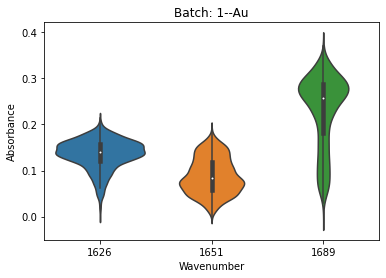

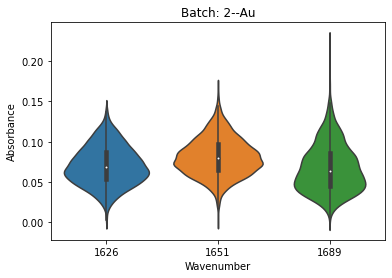

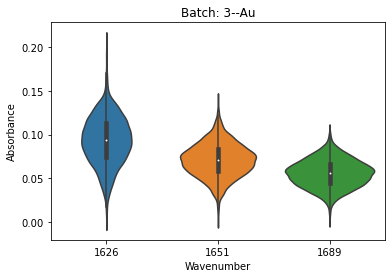

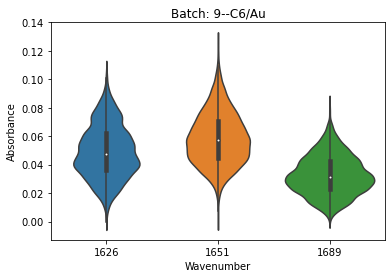

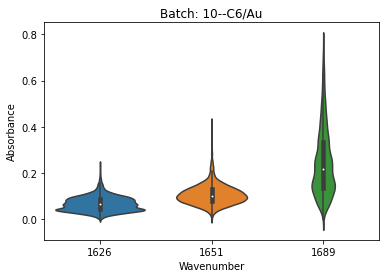

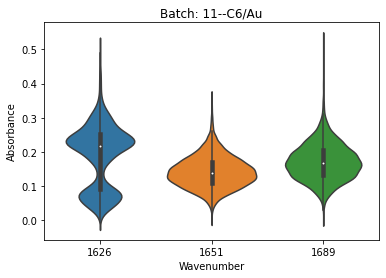

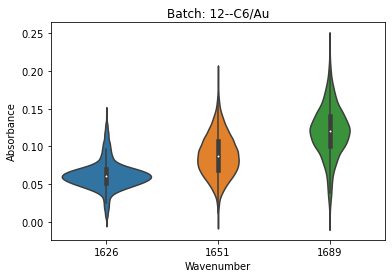

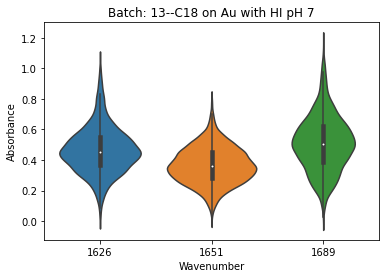

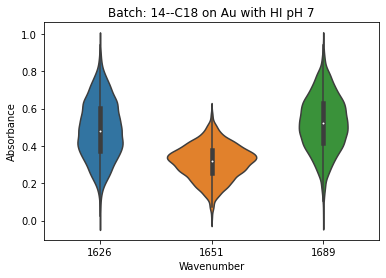

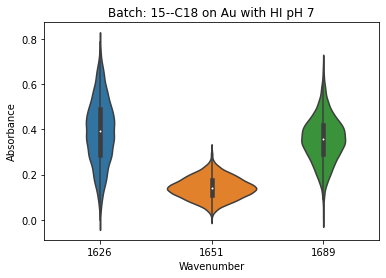

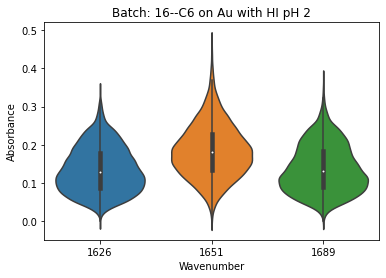

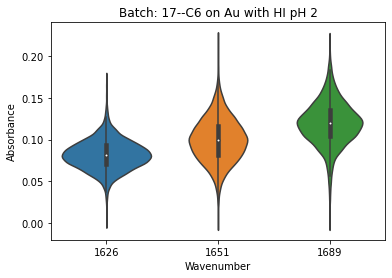

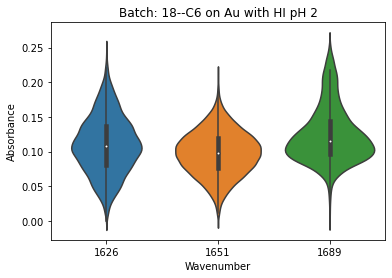

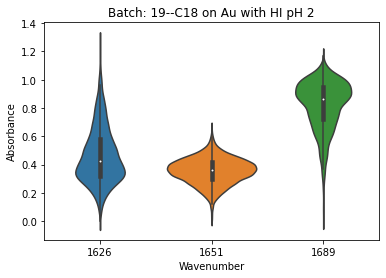

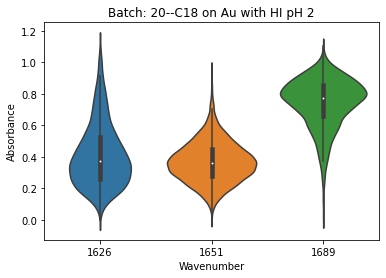

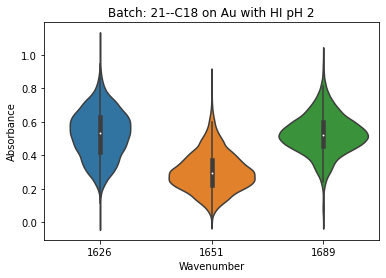

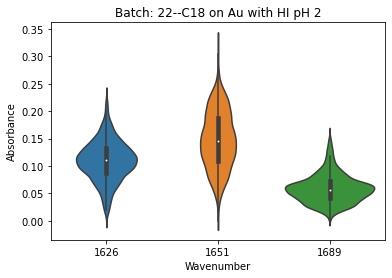

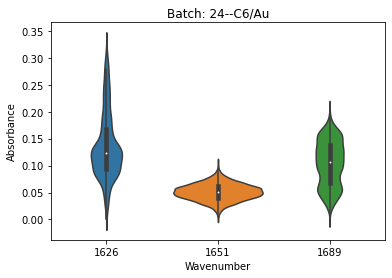

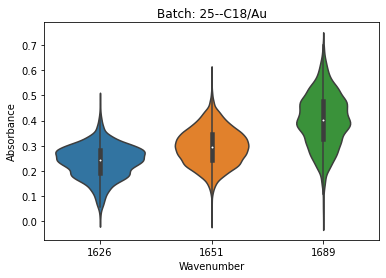

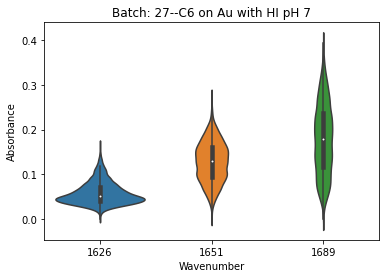

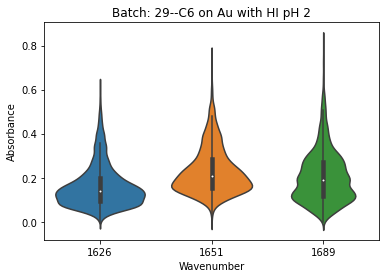

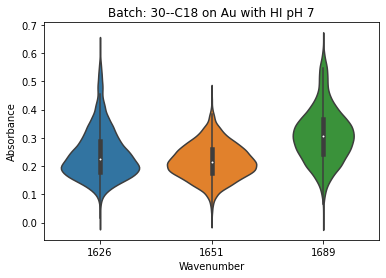

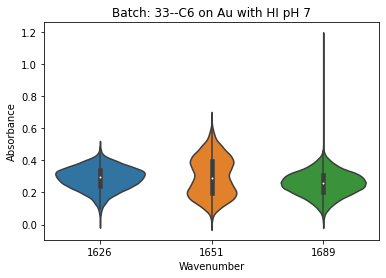

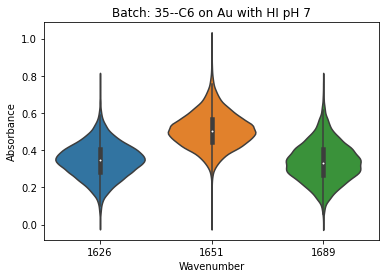

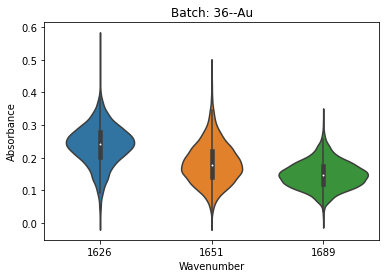

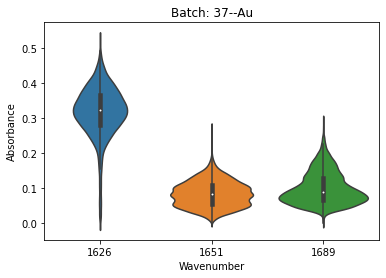

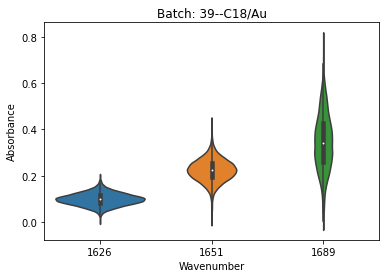

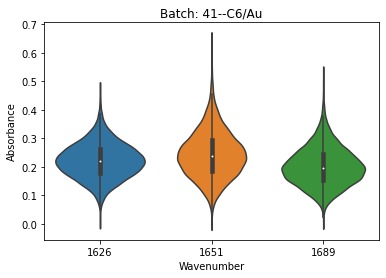

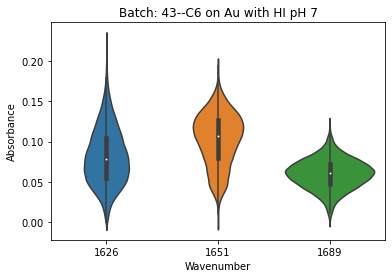

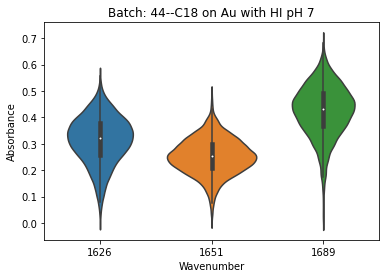

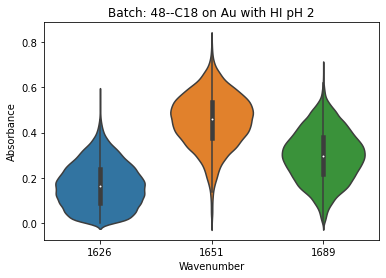

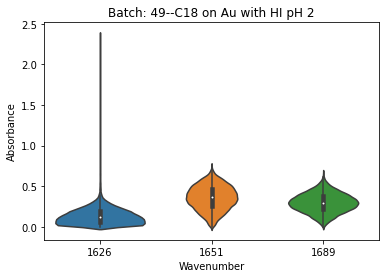

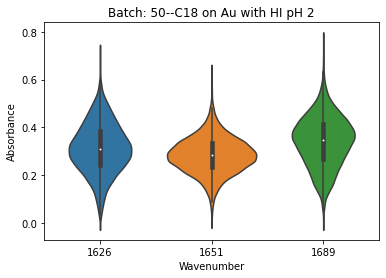

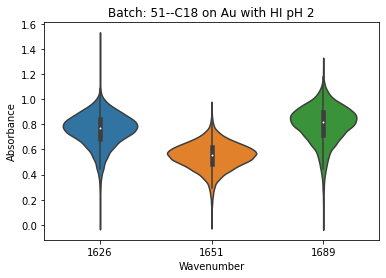

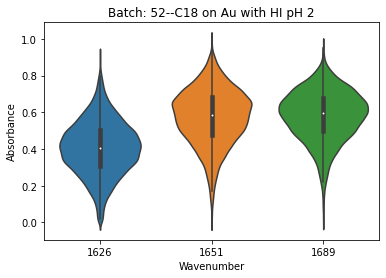

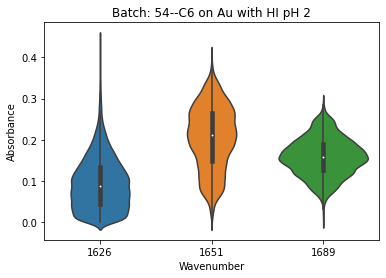

In [40]:
df.sample(3)

In [42]:
sk = scipy.stats.skew((fbsnom.flatten()*sensitivity)/(pulse_width*pulse_rate))
ku = scipy.stats.kurtosis((fbsnom.flatten()*sensitivity)/(pulse_width*pulse_rate))

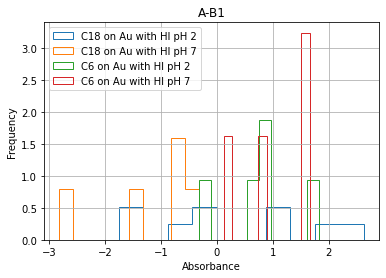

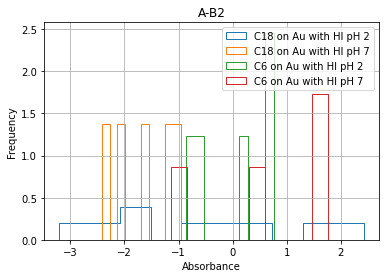

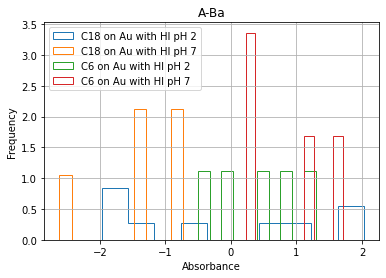

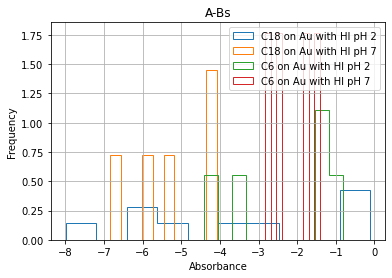

In [44]:
df['Skew'] = df.apply(lambda row: scipy.stats.skew((row['FSNOM'].flatten()*sensitivity)/(pulse_width*pulse_rate)), axis=1)
df['Kurtosis'] = df.apply(lambda row: scipy.stats.kurtosis((row['FSNOM'].flatten()*sensitivity)/(pulse_width*pulse_rate)), axis=1)
df['Kurtosis-3'] = df.apply(lambda row: scipy.stats.kurtosis((row['FSNOM'].flatten()*sensitivity)/(pulse_width*pulse_rate))-3, axis=1)

In [46]:
summary = all_data.reset_index().merge(df.query("Accept in ['y','Y']"), left_on='Batch',right_on='Batch').drop(['FSNOM','BSNOM'], axis=1)

summary = all_data.reset_index().merge(df, left_on='Batch',right_on='Batch').drop(['FSNOM','BSNOM'], axis=1)

In [48]:
summary.to_excel("Insulin_Summary_0801.xlsx")

In [191]:
with pd.ExcelWriter('./Insulin_Summary.xlsx') as writer:
    
    for samp_n, samp_df in summary.groupby('sample'):

        sn = samp_n.replace('/','_')

        samp_df.to_excel(writer, sheet_name=f'{sn}')

In [192]:
def cross_correlate(f,b):

    corr=correlate2d(f, b)

    new_i = np.unravel_index(corr.argmax(), corr.shape)

    fb=np.max([f.shape, b.shape], axis=0)

    output=np.zeros(fb)

    output[0:f.shape[0],0:f.shape[1]] = f
    output[-b.shape[0]:,-b.shape[1]:] = (output[-b.shape[0]:,-b.shape[1]:] + b)/2

    return output


NameError: name 'corr' is not defined

In [ ]:
hist, bins = np.histogram(corr.flatten(), bins=30)
width = 1.0 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

exp = np.sum(center*(hist/hist.sum()))
exp_i=np.argmin([exp-bin for bin in hist])
print(center[exp_i])

print(np.unravel_index(exp_i, corr.shape))

#plt.plot([bin-exp for bin in hist])
plt.axvline(exp,c='r')

plt.bar(center, hist, align='center', width=width)
plt.show()

In [ ]:
#corr[40:60, 80:100] = 0
#

name = '2720-0-'
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(ncols=2,nrows=2,figsize=(7,7))

f=SNOM_Import.plane_correct(df.iloc[2].FTOPO)
#f=df.iloc[2].FSNOM
b=SNOM_Import.plane_correct(df.iloc[2].BTOPO)
#b=df.iloc[2].BSNOM

output=cross_correlate(f, b)
corr=correlate2d(f, b)
new_i = np.unravel_index(corr.argmax(), corr.shape)

ax1.imshow(corr)
ax1.axhline(new_i[0],c='r')
ax1.axvline(new_i[1],c='r')

ax2.imshow(output)
ax3.imshow(f)
ax4.imshow(b)

print(f'F({f.shape})')
print(f'B({b.shape})')
print(f'O({output.shape})')

In [ ]:
df.iloc[0]

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=4)

for index, row in df.iterrows():

        im_file=row
        print(row.index)



        ftopo = im_file.FTOPO
        fsnom = im_file.FSNOM

        if not isinstance(ftopo, np.ndarray):

                continue

        plane = SNOM_Import.plane_correct(ftopo)

        print(row.background_scan)

        bkg = bkgs[row.background_scan[row.wavelength]]
        correction = row.sensitivity/bkg

        print(correction)

        plane_n = (plane)/plane.max()
        fsnom_n = (fsnom)/fsnom.max()

        print(im_file.fileName)

        data = {'FTOPO': im_file.FTOPO,
                'BTOPO': im_file.BTOPO,
                'FSNOM': im_file.FSNOM,
                'BSNOM': im_file.BSNOM,
                'FTOPO_Tilt_corrected': im_file.FTOPO-SNOM_Import.plane_correct(im_file.FTOPO),
                'BTOPO_Tilt_corrected': im_file.BTOPO-SNOM_Import.plane_correct(im_file.BTOPO),
                'FSNOM_Tilt_corrected': im_file.FSNOM-SNOM_Import.plane_correct(im_file.FSNOM),
                'BSNOM_Tilt_corrected': im_file.BSNOM-SNOM_Import.plane_correct(im_file.BSNOM)}

        if not os.path.exists(os.path.join(os.getcwd(), 'processed_images')):
                os.makedirs(os.path.join(os.getcwd(), 'processed_images'))

        sio.savemat(os.path.join(os.getcwd(), 'processed_images',f'{row.name}.mat'), data)

        for ax, (title, im) in zip(axes.flatten(), data.items()):

                ax.imshow(im)
                ax.set_title(title) 